# Analyze Region 7 - Svalbard and Jan Mayen

This notebook analyzes the largest glaciers and ice caps in Region 7 - Svalbard and Jan Mayen

This was the first region I analyzed so this notebook is not exactly the same as subsequent ones because I was trying to determine the best way to analyze them with this notebook. Because of this, it is also a bit messier than others.

Note that in the variable names two abbreviations are used to distinguish ice caps that were created by a manual dissolve or those created by an automated exploding script (ex = exploded, md = manual dissolve).

Note 6 April 2020, per conversations with the regional correspondant, removing Olav V as a candidate and using Asgardfonna instead. All instances of Olav V code are being commented out and Asgard code is being added.

Note 2 December 2020, per conversation with Michael Zemp, not going to include Jan Mayen since the we don't split up other regions and the Jan Mayen glaciers and ice cap are very small.

In [1]:
import os
import os.path as op
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import geopandas as gpd
from shapely.geometry import Polygon
import rasterio as rio
from rasterio.plot import plotting_extent
from earthpy import clip as cl
import earthpy.plot as ep

# set working dir
HOME = op.join(op.expanduser("~"))
os.chdir(os.path.join(HOME, "git/wgms-glacier-project"))

# Set up path to load scripts
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import scripts.wgms_scripts as ws

# Set Up Region Info

In [2]:
# Set region number, region name, and region index
# Once these are set, this notebook should run automatically for the specified region
region_number = "7"
region_name = "Svalbard and Jan Mayen"

# The variable primeclass needs to be updated with the primary class of the ice complexes for the region
# This may need to be a list in some instances
# 2: icefield, 3: ice cap, 4: outlet glacier, 5: valley glacier, 6: mountain glacier
# For Region 7, there are ice caps and outlet glaciers, so have to set up two primeclasses
primeclass1 = 3 # I set this value. These are ice caps, no other possible value it could be.
primeclass2 = 4 # I set this value. This value is an educated guess from knowledge of glaciers

# Note for the region index, region_index_1 should be one less than the region number and 
# region_index_2 should be equal to the region number. For example, for region 1, index_1 should be set to 0 and 
# index_2 should be set to 1, etc.
region_index_1 = 6
region_index_2 = 7

# * * * * * * * * * * * * * * * * Show Region 7 Outline * * * * * * * * * * * * * * * * *

In [3]:
# Open natural earth basemap TIF file
# ne_fp = 'data/natural-earth/NE1_50m_SR/NE1_50M_SR.tif' # 50 m res
ne_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W.tif' # 10 m res
with rio.open(ne_fp) as ne_src:
    # Convert / read the data into a numpy array:
    ne_raster = ne_src.read()
    ne_src_extent = plotting_extent(ne_src)
    bounds = ne_src.bounds
    ne_raster_meta = ne_src.meta

In [4]:
# Open glacier regions
glacier_regions_fp = "data/gtn-g-glacier-regions/cleaned/GTN-G_glacier_regions_201707_cleaned.shp"
glacier_regions = gpd.read_file(glacier_regions_fp)

# Extract Region outline
region_outline = glacier_regions[region_index_1:region_index_2]

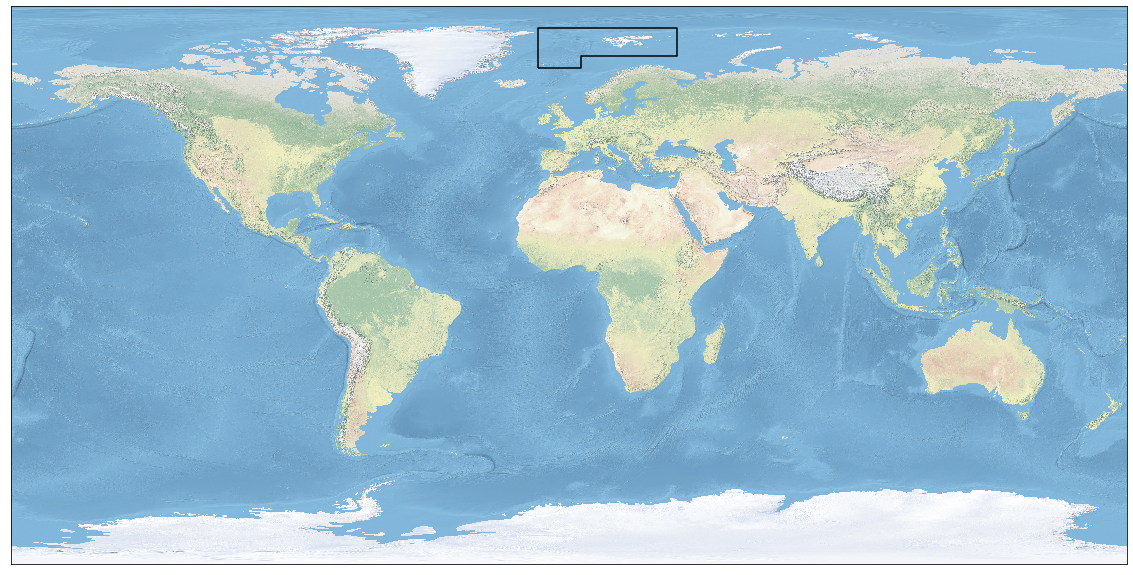

In [5]:
# Plot region 7 outline over the natural earth
# Plot natural earth basemap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot natural earth
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot region outline
region_outline.boundary.plot(ax=ax, color="black")

plt.show()

In [6]:
region_outline.bounds

minx  miny  maxx  maxy
6 -10.0  70.0  35.0  83.0

# * * * * * * * * * * * * * * * * Ice Cap Analysis * * * * * * * * * * * * * * * *

## Ten Largest for Svalbard and Jan Mayen

#### Data from exploded polygons

In [7]:
# Note that region 7 has two different largest files: one for svalbard and one for jan mayan
# This was done because the two regions are quite far apart from one another even though they are considered to be 
# in the same region

# Open region 7 svalbard largest ice caps file for epsg 3049
region_lg_svb_ex_3049_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                            region_number + "_epsg3049.shp"
ten_lg_region_7_svb_ex_3049_df = gpd.read_file(region_lg_svb_ex_3049_fn)

# Open region 7 svalbard largest ice caps file for epsg 32635
region_lg_svb_ex_32635_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                             region_number + "_epsg32635.shp"
ten_lg_region_7_svb_ex_32635_df = gpd.read_file(region_lg_svb_ex_32635_fn)

# Open region 7 jan mayen largest ice caps file for epsg 3058
region_lg_jm_ex_3058_fn = "data/glims/processed/ice-caps/largest/largest-ice-caps-region_" + \
                           region_number + "_jan_mayan_epsg3058.shp"
ten_lg_region_7_jm_ex_3058_df = gpd.read_file(region_lg_jm_ex_3058_fn)

In [8]:
# Print ten largest svalbard ice cap sizes - epsg 32635
ten_lg_region_7_svb_ex_32635_df

id         area                                           geometry
0    7  8371.122191  POLYGON ((18.914782 78.469039, 18.910191 78.46...
1  708  8061.240557  POLYGON ((24.946811 79.36035200000001, 24.9392...
2    8  5383.861122  POLYGON ((13.66026 78.255189, 13.660433 78.255...
3  431  4426.882180  POLYGON ((18.185957 77.56537, 18.185853 77.565...
4  706  2366.448387  POLYGON ((19.215861 79.764661, 19.215788 79.76...
5  215  1156.768149  POLYGON ((23.382094 77.464433, 23.422874 77.45...
6  638   646.076572  POLYGON ((33.482192 80.22808499999999, 33.4878...
7  871   509.478741  POLYGON ((21.936172 78.491522, 21.963917 78.49...
8  200   226.114519  POLYGON ((22.046245 77.567789, 22.04168 77.568...
9  762   160.705987  POLYGON ((20.493904 79.52167, 20.497456 79.520...

#### EPSG 3049 for Svalbard seems to be the best

In [9]:
# Print ten largest svalbard ice cap sizes - epsg 3049
ten_lg_region_7_svb_ex_3049_df

id         area                                           geometry
0    7  8402.703720  POLYGON ((18.914782 78.469039, 18.910191 78.46...
1  708  8077.403592  POLYGON ((24.946811 79.36035200000001, 24.9392...
2    8  5410.102716  POLYGON ((13.66026 78.255189, 13.660433 78.255...
3  431  4451.165085  POLYGON ((18.185957 77.56537, 18.185853 77.565...
4  706  2372.805757  POLYGON ((19.215861 79.764661, 19.215788 79.76...
5  215  1160.308733  POLYGON ((23.382094 77.464433, 23.422874 77.45...
6  638   646.149091  POLYGON ((33.482192 80.22808499999999, 33.4878...
7  871   511.149775  POLYGON ((21.936172 78.491522, 21.963917 78.49...
8  200   226.928046  POLYGON ((22.046245 77.567789, 22.04168 77.568...
9  762   161.182697  POLYGON ((20.493904 79.52167, 20.497456 79.520...

#### EPSG 3058 for Jan Mayen (Beerenberg) seems to be the best

In [10]:
# Print ten largest jan mayen ice cap sizes - epsg 3058
ten_lg_region_7_jm_ex_3058_df

id        area                                           geometry
0  33  118.792189  POLYGON ((-8.148241688999974 71.03465712100007...
1   4    0.222576  POLYGON ((-8.371137058999977 71.05213838300006...
2  19    0.189459  POLYGON ((-8.299012187999949 71.01444808500008...
3  15    0.177596  POLYGON ((-8.050405730999955 71.02550502200006...
4  22    0.167730  POLYGON ((-8.299847267999951 71.02116699800007...
5  18    0.146138  POLYGON ((-8.246046701999944 71.01434958300007...
6   3    0.139312  POLYGON ((-8.029386747999979 71.04128799700004...
7  12    0.138805  POLYGON ((-8.045878538999943 71.01626489100005...
8  17    0.126166  POLYGON ((-8.133996554999953 71.01466256800006...
9  14    0.117333  POLYGON ((-8.145961154999952 71.02406290300007...

#### Data from manually dissolved polygons

In [11]:
# Open CSV file that contains ice cap sizes for epsg 32635 that were created by a manual dissovle of the
# shapefiles as opposed to the automatic exploding of the ice caps
region_7_ice_caps_md_32635_fp = 'data/comparison/region-7-ice-cap-sizes-epsg32635.csv'
region_7_ice_caps_md_32635 = pd.read_csv(region_7_ice_caps_md_32635_fp)
region_7_ice_caps_md_32635

Ice Cap Name  GLIMS Area km^2  RGI Area km^2  Average Area km^2
0     Austfonna Ice Cap      8066.182528    8065.980900        8066.081714
1     Vestfonna Ice Cap      2376.444761    2376.441594        2376.443178
2  Olaf V Land Icefield      3869.044870    3848.620455        3858.832663
3   Asgardfonna Ice Cap      1541.256970    1541.257191        1541.257081
4    Beerenberg Ice Cap     -9999.000000     125.767349       -9999.000000

#### EPSG 3049 for Svalbard seems to be the best

In [12]:
# Open CSV file that contains ice cap sizes for epsg 3049 that were created by a manual dissovle of the
# shapefiles as opposed to the automatic exploding of the ice caps
region_7_ice_caps_md_3049_fp = 'data/comparison/region-7-ice-cap-sizes-epsg3049.csv'
region_7_ice_caps_md_3049 = pd.read_csv(region_7_ice_caps_md_3049_fp)
region_7_ice_caps_md_3049

Ice Cap Name  GLIMS Area km^2  RGI Area km^2  Average Area km^2
0     Austfonna Ice Cap      8082.355495    8082.153584        8082.254540
1     Vestfonna Ice Cap      2382.832660    2382.829486        2382.831073
2  Olaf V Land Icefield      4062.752007    4044.311798        4053.531903
3   Asgardfonna Ice Cap      1546.875244    1546.875466        1546.875355
4    Beerenberg Ice Cap     -9999.000000     128.655657       -9999.000000

In [13]:
str(round(region_7_ice_caps_md_3049.iloc[3]['GLIMS Area km^2'], 1))

'1546.9'

#### EPSG 3058 for Jan Mayen (Beerenberg) seems to be the best

In [14]:
# Open CSV file that contains ice cap sizes for epsg 3058 that were created by a manual dissovle of the
# shapefiles as opposed to the automatic exploding of the ice caps
# Note this file is only valid for jan mayen (Beerenberg Ice Cap) because epsg 3058 is jan mayen specific. 
# The other sizes of the ice caps are likely wrong since they are in Svalbard
region_7_ice_caps_md_3058_fp = 'data/comparison/region-7-ice-cap-sizes-epsg3058.csv'
region_7_ice_caps_md_3058 = pd.read_csv(region_7_ice_caps_md_3058_fp)
region_7_ice_caps_md_3058

Ice Cap Name  GLIMS Area km^2  RGI Area km^2  Average Area km^2
0     Austfonna Ice Cap      8147.266238    8147.062320        8147.164279
1     Vestfonna Ice Cap      2394.211793    2394.208600        2394.210196
2  Olaf V Land Icefield      3900.669015    3880.067824        3890.368420
3   Asgardfonna Ice Cap      1550.118196    1550.118418        1550.118307
4    Beerenberg Ice Cap     -9999.000000     121.472536       -9999.000000

In [15]:
# Open the 3 largest ice caps for Svalbard
# Note 6 April 2020, per conversations with the regional correspondant, removing Olav V as a candidate
# and using Asgardfonna instead
svalbard_1_ic_md_fp = "data/glims/processed/ice-caps/dissolved/austfonna-dissolved-outline_r7.shp"
svalbard_1_ic_md_df = gpd.read_file(svalbard_1_ic_md_fp)

#svalbard_2_ic_md_fp = "data/glims/processed/ice-caps/dissolved/olaf-v-land-dissolved-outline_r7.shp"
#svalbard_2_ic_md_df = gpd.read_file(svalbard_2_ic_md_fp)

svalbard_2_ic_md_fp = "data/glims/processed/ice-caps/dissolved/vestfonna-dissolved-outline_r7.shp"
svalbard_2_ic_md_df = gpd.read_file(svalbard_2_ic_md_fp)

svalbard_3_ic_md_fp = "data/glims/processed/ice-caps/dissolved/asgardfonna-dissolved-outline_r7.shp"
svalbard_3_ic_md_df = gpd.read_file(svalbard_3_ic_md_fp)

# Open Jan Mayen's ice cap file (it only has one)
jan_mayen_ic_md_fp = "data/rgi/processed/ice-caps/dissolved/beerenberg-dissolved-outline_r7.shp"
jan_mayen_ic_md_df = gpd.read_file(jan_mayen_ic_md_fp)

#### Plot all ice caps

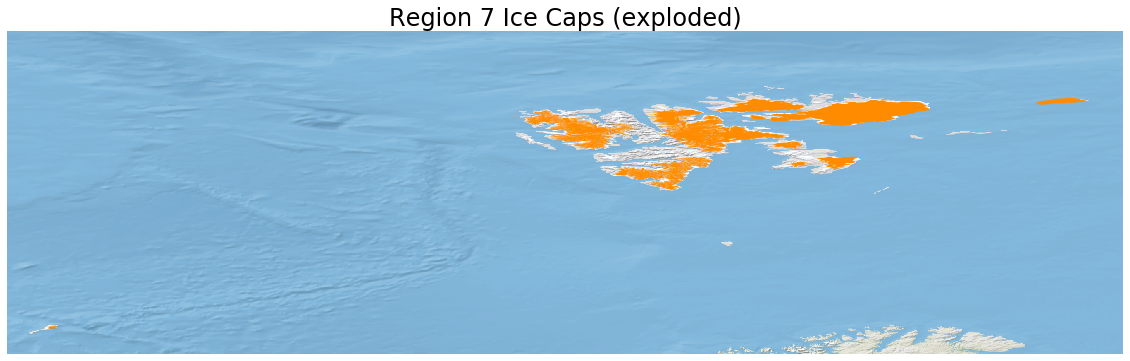

In [16]:
# Plot all region 7 ice caps in one frame (this is from the exploded file)
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = glacier_regions.loc[6:6].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest (note jan mayen is very small at the bottom left corner)
ten_lg_region_7_svb_ex_3049_df.plot(ax=ax, color="darkorange")
ten_lg_region_7_jm_ex_3058_df.plot(ax=ax, color="darkorange")
ax.set_title('Region 7 Ice Caps (exploded)', fontsize=24)
ax.set_axis_off()

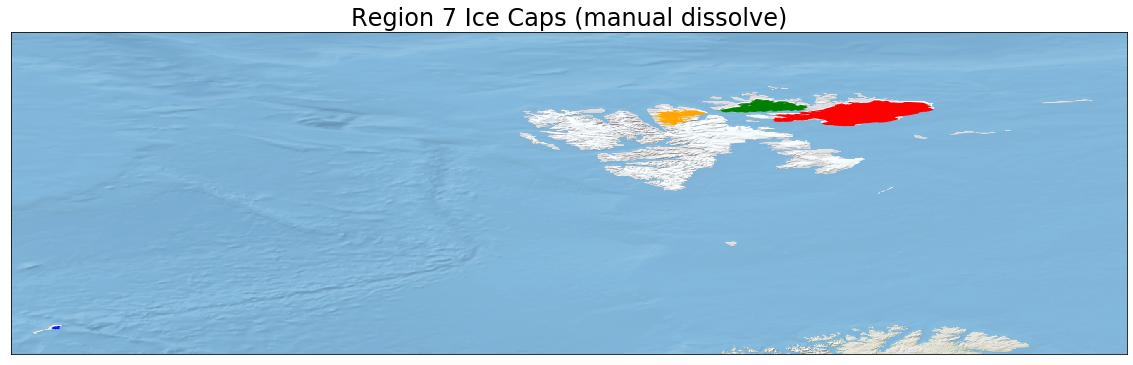

In [17]:
# Plot all region 7 ice caps over natural earth background from the manually dissolved files
# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = glacier_regions.loc[6:6].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest (note jan mayen is very small at the bottom left corner)
svalbard_1_ic_md_df.plot(ax=ax, color='red')
svalbard_2_ic_md_df.plot(ax=ax, color='green')
svalbard_3_ic_md_df.plot(ax=ax, color='orange')
jan_mayen_ic_md_df.plot(ax=ax, color='blue')
ax.set_title('Region 7 Ice Caps (manual dissolve)', fontsize=24)

plt.show()

## Svalbard Ice Caps

In [18]:
# Need to split Svalbard from Jan Mayen, so create a clipping polygon for Svalbard area
# Create dataframe that holds the clipping box
svalbard_points = Polygon([(10.0, 81.0), (35.0, 81.0),
                                 (35.0, 74.0), (10.0, 74.0), 
                                 (10.0, 81.0)])
svalbard_gdf = gpd.GeoDataFrame([1],
                                 geometry=[svalbard_points],
                                 crs={'init': 'epsg:4362'})

In [19]:
# Select the 5 largest svalbard ice caps
svalbard_largest_ic_ex_df = ten_lg_region_7_svb_ex_3049_df[['id', 'area', 'geometry']].nlargest(5, 'area')

In [20]:
svalbard_largest_ic_ex_df

id         area                                           geometry
0    7  8402.703720  POLYGON ((18.914782 78.469039, 18.910191 78.46...
1  708  8077.403592  POLYGON ((24.946811 79.36035200000001, 24.9392...
2    8  5410.102716  POLYGON ((13.66026 78.255189, 13.660433 78.255...
3  431  4451.165085  POLYGON ((18.185957 77.56537, 18.185853 77.565...
4  706  2372.805757  POLYGON ((19.215861 79.764661, 19.215788 79.76...

In [21]:
# Pull out olav V ice cap (this is stuck to another ice cap so will need to split them)
# olaf_v_asgardfonna_ex_ic = svalbard_largest_ic_ex_df.iloc[0:1]

In [22]:
# Pull out Asgardfonna ice cap (this is stuck to another ice cap so will need to split them)
asgardfonna_olav_v_ex_ic_df = svalbard_largest_ic_ex_df.iloc[0:1]

In [23]:
# Pull out austfonna ice cap
austfonna_ex_ic_df = svalbard_largest_ic_ex_df.iloc[1:2]

In [24]:
# Pull out vestfonna ice cap
vestfonna_ex_ic_df = svalbard_largest_ic_ex_df.iloc[4:5]

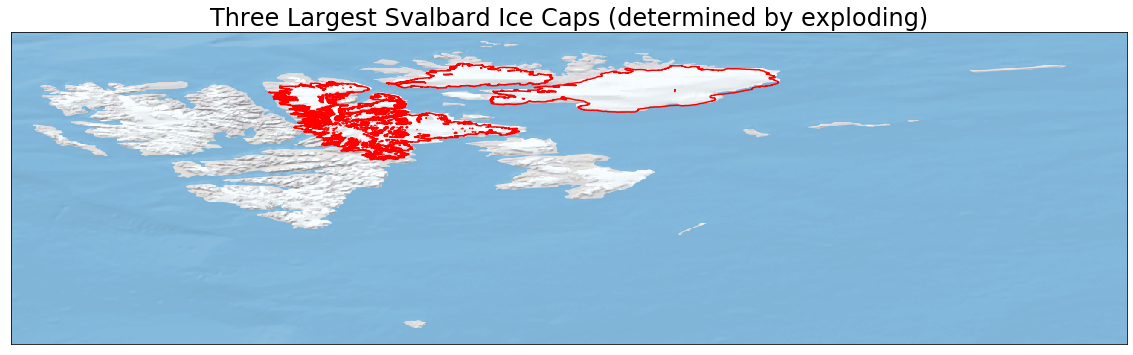

In [25]:
# Plot Svalbard ice caps over natural earth background from the exploded files
# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = svalbard_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest shapefile from jan mayen dataframe - this will be the main jan mayen ice cap
austfonna_ex_ic_df.boundary.plot(ax=ax, color='red')
asgardfonna_olav_v_ex_ic_df.boundary.plot(ax=ax, color='red')
vestfonna_ex_ic_df.boundary.plot(ax=ax, color='red')
ax.set_title('Three Largest Svalbard Ice Caps (determined by exploding)', fontsize=24)

plt.show()

#### Clip Olaf V away from the other ice caps - no longer using this

In [26]:
# Create a clipping polygon for Olaf Icefield
# Note: It was very hard to define where this ice cap ended because it shares a side with Balderfonna Ice Cap
# Create dataframe that holds the clipping box
#olaf_area_points = Polygon([(19.6875, 78.4686), (18.3032, 78.4444),
#                            (18.1769, 79.2444), (19.9622, 79.2310), 
#                            (20.0006, 79.0133), (21.5387, 78.9598), 
#                            (21.5277, 78.6570), (19.6875, 78.4686)])
#olaf_area_points = Polygon([(19.9951, 79.1517), (18.9185, 79.2136),
#                             (18.5779, 79.0060), (17.1826, 79.0395), 
#                             (17.0618, 78.8541), (17.2925, 78.5485),
#                             (18.9185, 78.3061), (20.2039, 78.6137),
#                             (21.5112, 78.6614), (21.7310, 78.8371),
#                             (19.9841, 79.0290), (19.9951, 79.1517)])

#olaf_gdf = gpd.GeoDataFrame([1],
#                            geometry=[olaf_area_points],
#                            crs={'init': 'epsg:4362'})

#olaf_clip_ex_region = cl.clip_shp(olaf_v_asgardfonna_ex_ic, olaf_gdf)

In [27]:
# Determine area of this clipped olaf region
#olaf_clip_ex_area = olaf_clip_ex_region['geometry'].to_crs({'init': 'epsg:3049'}).area/10**6
#round(olaf_clip_ex_area[0], 6)

In [28]:
# Plot Olaf V
# Set up plot space
#fig, ax = plt.subplots(figsize=(20,20))
#minx, miny, maxx, maxy = svalbard_gdf.total_bounds
#ax.set_xlim(minx, maxx)
#ax.set_ylim(miny, maxy)

# Plot natural earth basemap
#ep.plot_rgb(ne_raster,
#            rgb=[0, 1, 2],
#            extent=ne_src_extent,
#            ax=ax)

# Plot
#olaf_clip_ex_region.plot(ax=ax, color='darkorange')
#svalbard_2_ic_md_df.plot(ax=ax, color='red')
#olaf_gdf.boundary.plot(ax=ax, color='green')
#ax.set_title('Olaf V land regions. (Orange is exploded, red is dissolved)', fontsize=24)

#plt.show()

#### Clip Asgardfonna away from the other ice caps

In [29]:
# Create a clipping polygon for Olaf Icefield
# Note: It was very hard to define where this ice cap ended because it shares a side with Balderfonna Ice Cap
# Create dataframe that holds the clipping box
asgard_area_points = Polygon([(15.1392, 79.9138), (15.4578, 79.8501),
                              (17.7539, 79.9943), (18.2922, 79.7019), 
                              (17.3584, 79.4636), (17.4023, 79.3707),
                              (17.0837, 79.3118), (16.7542, 79.2218),
                              (15.9741, 79.2033), (15.1392, 79.9138),])

asgard_gdf = gpd.GeoDataFrame([1],
                            geometry=[asgard_area_points],
                            crs={'init': 'epsg:4362'})

asgardfonna_ex_ic_df = cl.clip_shp(asgardfonna_olav_v_ex_ic_df, asgard_gdf)

In [30]:
# Determine area of this clipped asgard region
asgardfonna_ex_area = asgardfonna_ex_ic_df['geometry'].to_crs({'init': 'epsg:3049'}).area/10**6
round(asgardfonna_ex_area[0], 6)

1586.593843

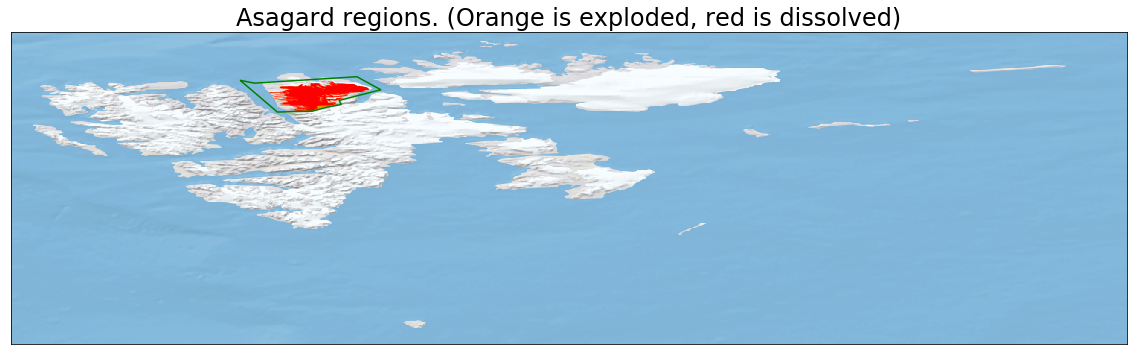

In [31]:
# Plot Asgard
# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = svalbard_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot
asgardfonna_ex_ic_df.plot(ax=ax, color='darkorange')
svalbard_3_ic_md_df.plot(ax=ax, color='red')
asgard_gdf.boundary.plot(ax=ax, color='green')
ax.set_title('Asagard regions. (Orange is exploded, red is dissolved)', fontsize=24)

plt.show()

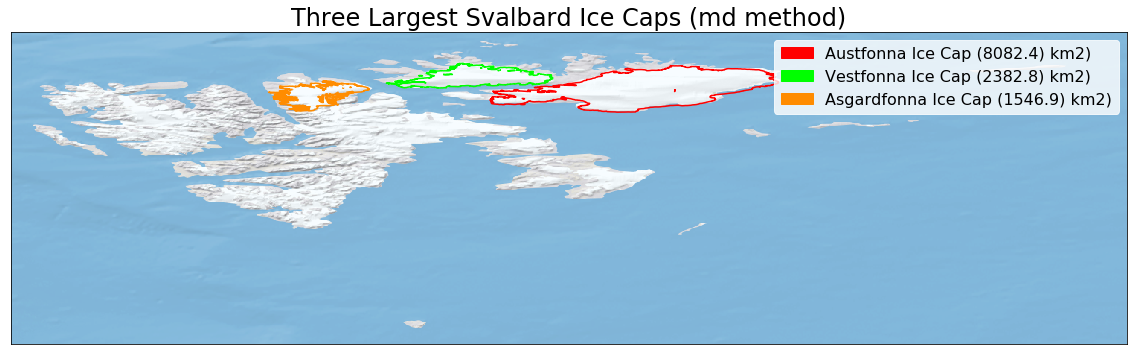

In [32]:
# Plot Svalbard ice caps over natural earth background from the manually dissolved files
# Set up legend
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = ['Austfonna Ice Cap (' + str(round(region_7_ice_caps_md_3049.iloc[0]['GLIMS Area km^2'], 1)) + ') km2)',
                 'Vestfonna Ice Cap (' + str(round(region_7_ice_caps_md_3049.iloc[1]['GLIMS Area km^2'], 1)) + ') km2)', 
                 'Asgardfonna Ice Cap (' + str(round(region_7_ice_caps_md_3049.iloc[3]['GLIMS Area km^2'], 1)) + ') km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = svalbard_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest shapefile from jan mayen dataframe - this will be the main jan mayen ice cap
svalbard_1_ic_md_df.boundary.plot(ax=ax, color='red')
svalbard_2_ic_md_df.boundary.plot(ax=ax, color='lime')
svalbard_3_ic_md_df.boundary.plot(ax=ax, color='darkorange')
ax.set_title('Three Largest Svalbard Ice Caps (md method)', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 16,
         bbox_to_anchor = (1.0,1.0))

plt.show()

In [33]:
svalbard_1_ic_md_df

glac_id     area  db_area  width   length  primeclass  min_elev  \
0  G023559E79453N  1095.79  1095.86    0.0  45905.5         0.0       0.0   

   mean_elev  max_elev             src_date                 glac_name  \
0        0.0       0.0  2001-07-10T00:00:00  Austfonna, Bråsvellbreen   

                                            geometry  
0  (POLYGON Z ((21.478438 79.36850699999999 0, 21...

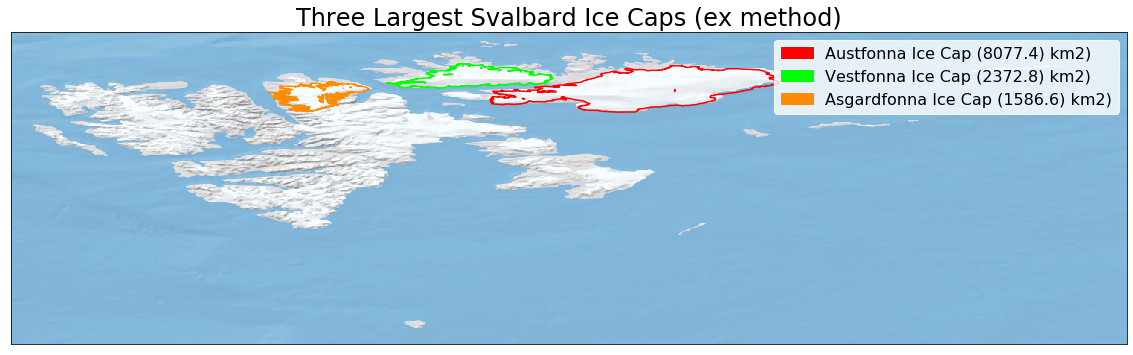

In [34]:
# Plot Svalbard ice caps over natural earth background from the manually dissolved for austfonna and vestfonna
# but from exploded and clipped for Olaf V files - those 3 shapefiles seem to be the best ones for Svalbard
# Set up legend
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = ['Austfonna Ice Cap (' + str(round(austfonna_ex_ic_df.iloc[0]['area'], 1)) + ') km2)',
                'Vestfonna Ice Cap (' + str(round(vestfonna_ex_ic_df.iloc[0]['area'], 1)) + ') km2)', 
                 'Asgardfonna Ice Cap (' + str(round(asgardfonna_ex_area[0], 1)) + ') km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = svalbard_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot ice caps
#svalbard_1_ic_md_df.boundary.plot(ax=ax, color='darkorange')
austfonna_ex_ic_df.boundary.plot(ax=ax, color='red')
#olaf_clip_ex_region.boundary.plot(ax=ax, color='lime')
#svalbard_2_ic_md_df.boundary.plot(ax=ax, color='lime')
vestfonna_ex_ic_df.boundary.plot(ax=ax, color='lime')
asgardfonna_ex_ic_df.boundary.plot(ax=ax, color='darkorange')
ax.set_title('Three Largest Svalbard Ice Caps (ex method)', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 16,
         bbox_to_anchor = (1.0,1.0))

plt.show()

In [35]:
str(round(vestfonna_ex_ic_df.iloc[0]['area'], 1))

'2372.8'

### Svalbard Ice Cap Measurement Dates
Because the ice caps were created by exploding many glacier outlines into one, will need to get the measurement dates from all the glaciers in the ice cap and then show a range of the earliest measurement to the latest for ice cap measurement dates.

In [36]:
# Open GLIMS shapefile with all of the glacier outlines
glims_glaciers_fn = "data/glims/processed/cleaned/glims_region_" + region_number + "_cleaned.shp"
glims_glaciers_df = gpd.read_file(glims_glaciers_fn)

In [37]:
# Get glaciers that are in Austfonna Ice Cap
austfonna_mask = ws.pip(glims_glaciers_df, svalbard_1_ic_md_df)
austfonna_glaciers = glims_glaciers_df.loc[austfonna_mask]

# Print the minimum date and the maximum date
austfonna_glaciers_min_date = austfonna_glaciers['src_date'].min()[0:10]
austfonna_glaciers_max_date = austfonna_glaciers['src_date'].max()[0:10]
print(austfonna_glaciers_min_date)
print(austfonna_glaciers_max_date)

2001-07-10
2008-08-14


In [38]:
# Get glaciers that are in Olaf V Ice Cap
#olaf_mask = ws.pip(glims_glaciers_df, olaf_clip_ex_region) # from exploded
#olaf_mask = ws.pip(glims_glaciers_df, svalbard_2_ic_md_df) # from manual dissolve
#olaf_glaciers = glims_glaciers_df.loc[olaf_mask]

# Print the minimum date and the maximum date
#olaf_glaciers_min_date = olaf_glaciers['src_date'].min()
#olaf_glaciers_max_date = olaf_glaciers['src_date'].max()
#print(olaf_glaciers_min_date)
#print(olaf_glaciers_max_date)

In [39]:
# Get glaciers that are in Vestfonna Ice Cap
vestfonna_mask = ws.pip(glims_glaciers_df, svalbard_2_ic_md_df)
vestfonna_glaciers = glims_glaciers_df.loc[vestfonna_mask]

# Print the minimum date and the maximum date
vestfonna_glaciers_min_date = vestfonna_glaciers['src_date'].min()[0:10]
vestfonna_glaciers_max_date = vestfonna_glaciers['src_date'].max()[0:10]
print(vestfonna_glaciers_min_date)
print(vestfonna_glaciers_max_date)

2008-07-23
2008-08-14


In [40]:
# Get glaciers that are in Asgard Ice Cap
#asgard_mask = ws.pip(glims_glaciers_df, asgardfonna_ex_ic_df) # from exploded
asgard_mask = ws.pip(glims_glaciers_df, svalbard_3_ic_md_df) # from manual dissolve
asgard_glaciers = glims_glaciers_df.loc[asgard_mask]

# Print the minimum date and the maximum date
asgard_glaciers_min_date = asgard_glaciers['src_date'].min()[0:10]
asgard_glaciers_max_date = asgard_glaciers['src_date'].max()[0:10]
print(asgard_glaciers_min_date)
print(asgard_glaciers_max_date)

2002-07-12
2008-06-07


In [41]:
svalbard_3_ic_md_df

glac_id     area  db_area  width   length  primeclass  min_elev  \
0  G016639E79309N  77.5271  77.5864    0.0  11439.7         0.0       0.0   

   mean_elev  max_elev             src_date      glac_name  \
0        0.0       0.0  2008-06-07T00:00:00  Ringhornbreen   

                                            geometry  
0  (POLYGON Z ((17.189001 79.451611 0, 17.186248 ...

In [42]:
svalbard_3_ic_md_df_area = svalbard_3_ic_md_df['geometry'].to_crs({'init': 'epsg:3049'}).area/10**6
round(svalbard_3_ic_md_df_area[0], 6)

1546.875244

In [43]:
# Select just what is needed from svalbard_2_ic_md_df (Olav V)
#olaf_ic_md_df = svalbard_2_ic_md_df[['glac_id', 'area', 'geometry']]

# Rename glac_id column to id to match austfonna_ex_ic_df
#olaf_ic_md_df = olaf_ic_md_df.rename(columns={'glac_id': 'id'})

# Update the id number
#olaf_ic_md_df.iloc[0, olaf_ic_md_df.columns.get_loc('id')] = 890
#olaf_ic_md_df

In [44]:
# Select just what is needed from svalbard_3_ic_md_df (Asgardfonna)
asgard_ic_md_df = svalbard_3_ic_md_df[['glac_id', 'area', 'geometry']]

# Rename glac_id column to id to match austfonna_ex_ic_df
asgard_ic_md_df = asgard_ic_md_df.rename(columns={'glac_id': 'id'})

# Update the id number
asgard_ic_md_df.iloc[0, asgard_ic_md_df.columns.get_loc('id')] = 890
asgard_ic_md_df

id     area                                           geometry
0  890  77.5271  (POLYGON Z ((17.189001 79.451611 0, 17.186248 ...

### Save Svalbard Ice Caps to Shapefile
Create dataframe with all the appropriate attributes: name, area, date, geometry using the exploded versions of the ice caps.

In [45]:
# Correct the area for Olav V ice cap exploded version
#olaf_clip_ex_region.iloc[0, olaf_clip_ex_region.columns.get_loc('area')] = round(olaf_clip_ex_area[0], 6)

# Correct the area for Olav V ice cap dissolved version
#olaf_ic_md_df.iloc[0, olaf_ic_md_df.columns.get_loc('area')] = round(svalbard_2_ic_md_df_area[0], 6)

# Correct the area in the dataframe for Asgard ice cap exploded version - going with exploded version
asgardfonna_ex_ic_df.iloc[0, asgardfonna_ex_ic_df.columns.get_loc('area')] = round(asgardfonna_ex_area[0], 6)

# Correct the area in the dataframe for Asgard ice cap dissolved version - NOT using disolved version
# asgard_ic_md_df.iloc[0, asgard_ic_md_df.columns.get_loc('area')] = round(svalbard_3_ic_md_df_area[0], 6)

# Merge the three largest svalbard ice caps to one dataframe
#final_sv_ice_caps_df = pd.concat([austfonna_ex_ic_df, olaf_clip_ex_region, olaf_ic_md_df, vestfonna_ex_ic_df])
final_sv_ice_caps_df = pd.concat([austfonna_ex_ic_df, vestfonna_ex_ic_df, asgardfonna_ex_ic_df])

# Add ice cap name to its dataframe
#name = ["Austfonna", "Olav V exp", "Olav V dis", "Vestfonna"]
name = ["Austfonna Ice Cap", "Vestfonna Ice Cap", "Asgardfonna Ice Cap"]
final_sv_ice_caps_df["ic_name"] = name

# Add the min date of the ice cap measurement
#min_date = [austfonna_glaciers_min_date, olaf_glaciers_min_date, olaf_glaciers_min_date, vestfonna_glaciers_min_date]
min_date = [austfonna_glaciers_min_date, vestfonna_glaciers_min_date, asgard_glaciers_min_date]
final_sv_ice_caps_df["min_date"] = min_date

# Add the max date of the ice cap measurement
#max_date = [austfonna_glaciers_max_date, olaf_glaciers_max_date, olaf_glaciers_max_date, vestfonna_glaciers_max_date]
max_date = [austfonna_glaciers_max_date, vestfonna_glaciers_max_date, asgard_glaciers_max_date]
final_sv_ice_caps_df["max_date"] = max_date

# Add region number
final_sv_ice_caps_df["region_no"] = region_number

# Add region name
final_sv_ice_caps_df["reg_name"] = region_name

# Add primeclass
final_sv_ice_caps_df["primeclass"] = primeclass1

# Reorder columns
final_sv_ice_caps_df = final_sv_ice_caps_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 'min_date', 
                                             'max_date', 'geometry']]
# Rename the area column
final_sv_ice_caps_df.rename(columns={'area': 'area_km2'}, inplace=True)
                                     
# Reset index
final_sv_ice_caps_df = final_sv_ice_caps_df.reset_index(drop=True)

In [46]:
final_sv_ice_caps_df

region_no                reg_name              ic_name  primeclass  \
0         7  Svalbard and Jan Mayen    Austfonna Ice Cap           3   
1         7  Svalbard and Jan Mayen    Vestfonna Ice Cap           3   
2         7  Svalbard and Jan Mayen  Asgardfonna Ice Cap           3   

      area_km2    min_date    max_date  \
0  8077.403592  2001-07-10  2008-08-14   
1  2372.805757  2008-07-23  2008-08-14   
2  1586.593843  2002-07-12  2008-06-07   

                                            geometry  
0  POLYGON ((24.946811 79.36035200000001, 24.9392...  
1  POLYGON ((19.215861 79.764661, 19.215788 79.76...  
2  (POLYGON ((16.75903047879151 79.22311940240132...

In [47]:
# Save
zipfile_sv_ic_fp = "data/final-dataset/region-" + region_number + "-largest-complexes.zip"
if os.path.exists(zipfile_sv_ic_fp) == False:
    # Create the shapefile
    final_sv_ic_fp = "data/final-dataset/region-" + region_number + "-largest-complexes.shp"
    final_sv_ice_caps_df.to_file(driver='ESRI Shapefile', filename=final_sv_ic_fp)
    
    # Zip up the shapefile
    zipfile_sv_ic_fp = ws.zipshp(final_sv_ic_fp, Delete=True)
    print("Creating zipfile: " + zipfile_sv_ic_fp)
else:
    print(zipfile_sv_ic_fp + " already extists")

Creating zipfile: data/final-dataset\region-7-largest-complexes.zip


## Jan Mayen Ice Caps

In [48]:
# Need to separate Jan Mayen from Svalbard, so create a clipping polygon for Jan Mayan for plotting the Jan Mayen glaciers
# Create dataframe that holds the clipping box
jan_mayen_points = Polygon([(-9.5691, 71.5205), (-7.2620, 71.5205),
                                 (-7.2620, 70.5136), (-9.5691, 70.5136), 
                                 (-9.5691, 71.5205)])
jan_mayen_gdf = gpd.GeoDataFrame([1],
                                 geometry=[jan_mayen_points],
                                 crs={'init': 'epsg:4362'})

In [49]:
# Select the largest jan mayan ice caps since most of the shapefiles are very tiny except for one
jan_mayen_largest_ic_ex_df = ten_lg_region_7_jm_ex_3058_df[['id', 'area', 'geometry']].nlargest(1, 'area')
jan_mayen_largest_ic_ex_df

id        area                                           geometry
0  33  118.792189  POLYGON ((-8.148241688999974 71.03465712100007...

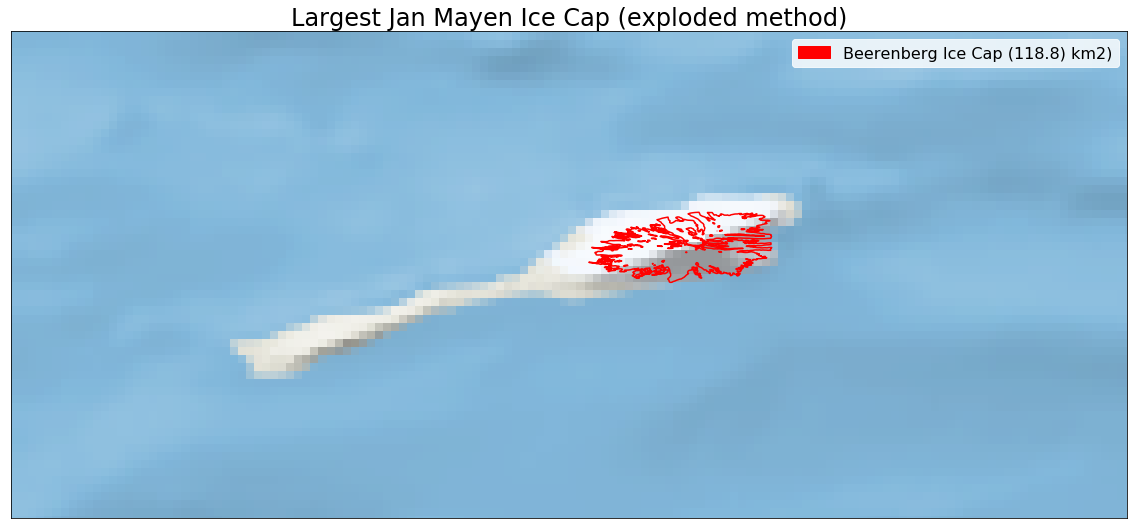

In [50]:
# Plot Jan Mayen ice cap (exploded version) over natural earth background
# Set up legend
legend_colors = ['red']
legend_labels = ['Beerenberg Ice Cap (' + str(round(jan_mayen_largest_ic_ex_df.iloc[0]['area'],1)) + ') km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = jan_mayen_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest shapefile from jan mayen dataframe - this will be the main jan mayen ice cap
jan_mayen_largest_ic_ex_df.boundary.plot(ax=ax, color='red')
#ax.set_title('Largest Jan Mayen Ice Cap (exploded)', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 16,
         bbox_to_anchor = (1.0,1.0))
ax.set_title('Largest Jan Mayen Ice Cap (exploded method)', fontsize=24)

plt.show()

In [51]:
jan_mayen_largest_ic_ex_df

id        area                                           geometry
0  33  118.792189  POLYGON ((-8.148241688999974 71.03465712100007...

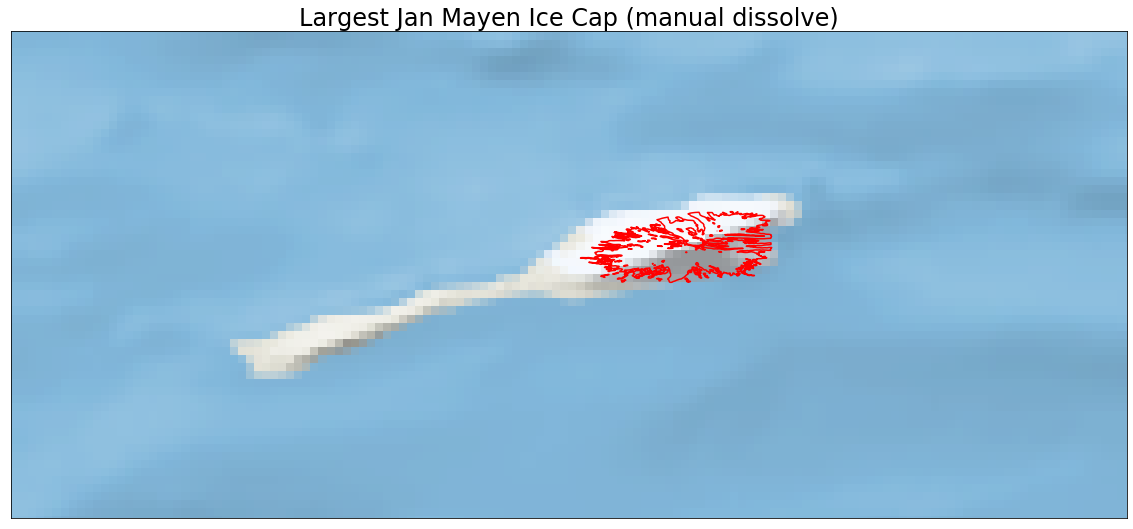

In [52]:
# Plot Jan Mayen ice cap (manual dissolve version) over natural earth background
# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = jan_mayen_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest shapefile from jan mayen dataframe - this will be the main jan mayen ice cap
jan_mayen_ic_md_df.boundary.plot(ax=ax, color='red')
ax.set_title('Largest Jan Mayen Ice Cap (manual dissolve)', fontsize=24)

plt.show()

In [53]:
jan_mayen_ic_md_df

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-07.01568  G351816E71042N  19759999  -9999999 -8.18374  71.0416   

  O2Region    Area  Zmin  Zmax  ...  Aspect  Lmax  Status  Connect  Form  \
0        2  15.399   151  2175  ...     188  4678       0        0     0   

   TermType  Surging  Linkages                   Name  \
0         0        9         9  NO4W00110001 Sorbreen   

                                            geometry  
0  (POLYGON ((-8.029386747999979 71.0412879970000...  

[1 rows x 22 columns]

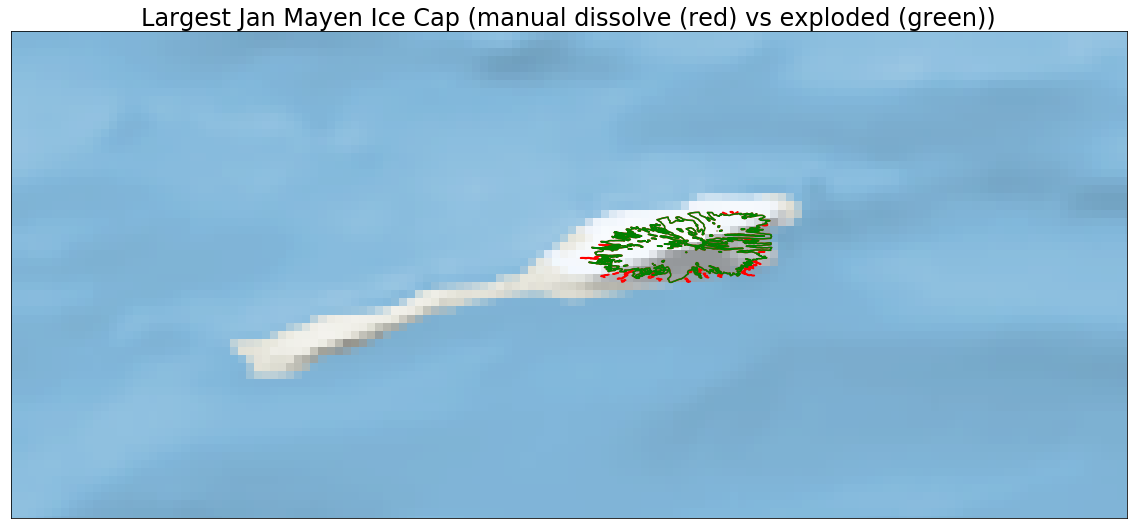

In [54]:
# plot jan mayen ice cap - exploded version and manual dissolve version on top of one another
# Plot Jan Mayen ice cap (manual dissolve version) over natural earth background
# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = jan_mayen_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot largest shapefile from jan mayen dataframe - this will be the main jan mayen ice cap
jan_mayen_ic_md_df.boundary.plot(ax=ax, color='red')
jan_mayen_largest_ic_ex_df.boundary.plot(ax=ax, color='green')
ax.set_title('Largest Jan Mayen Ice Cap (manual dissolve (red) vs exploded (green))', fontsize=24)

plt.show()

### Jan Mayan Ice Cap Measurement Dates
Because the ice caps were created by exploding many glacier outlines into one, will need to get the measurement dates from all the glaciers in the ice cap and then show a range of the earliest measurement to the latest for ice cap measurement dates.

In [55]:
# Open RGI region 7 data with all of the glaciers outlines (GLIMS doesn't have Jan Mayen)
rgi_glaciers_df = ws.open_rgi_region(int(region_number))

In [56]:
# Get glaciers that are in Beerenberg Ice Cap
beerenberg_mask = ws.pip(rgi_glaciers_df, jan_mayen_largest_ic_ex_df)
beerenberg_glaciers = rgi_glaciers_df.loc[beerenberg_mask]

# Format and print the minimum date and the maximum date
beerenberg_glaciers_min_date = beerenberg_glaciers['BgnDate'].min()[0:10]
beerenberg_glaciers_max_date = beerenberg_glaciers['BgnDate'].max()[0:10]
beerenberg_glaciers_min_date = beerenberg_glaciers_min_date[0:4] + "-" + beerenberg_glaciers_min_date[4:6] + "-" + \
                               beerenberg_glaciers_min_date[6:8]
beerenberg_glaciers_max_date = beerenberg_glaciers_max_date[0:4] + "-" + beerenberg_glaciers_max_date[4:6] + "-" + \
                               beerenberg_glaciers_max_date[6:8]
print(beerenberg_glaciers_min_date)
print(beerenberg_glaciers_max_date)

1975-99-99
1975-99-99


### Save Jan Mayen ice cap to shapefile
Create dataframe with all the appropriate attributes: name, area, date, geometry using the exploded versions of the ice caps.

In [57]:
# Drop id from dataframe
final_jm_ice_caps_df = jan_mayen_largest_ic_ex_df.drop("id", axis=1)

# Add name to dataframe
name = "Beerenberg Ice Cap"
final_jm_ice_caps_df["ic_name"] = name

# Add min_date and max_date
final_jm_ice_caps_df["min_date"] = beerenberg_glaciers_min_date
final_jm_ice_caps_df["max_date"] = beerenberg_glaciers_max_date

# Add region number
final_jm_ice_caps_df["region_no"] = region_number

# Add regin name
final_jm_ice_caps_df["reg_name"] = region_name

# Add primeclass
final_jm_ice_caps_df["primeclass"] = primeclass1

# Reorder columns
final_jm_ice_caps_df = final_jm_ice_caps_df[['region_no', 'reg_name', 'ic_name', 'primeclass', 'area', 
                                             'min_date', 'max_date', 'geometry']]

# Rename the area column
final_jm_ice_caps_df.rename(columns={'area': 'area_km2'}, inplace=True)

In [58]:
final_jm_ice_caps_df

region_no                reg_name             ic_name  primeclass  \
0         7  Svalbard and Jan Mayen  Beerenberg Ice Cap           3   

     area_km2    min_date    max_date  \
0  118.792189  1975-99-99  1975-99-99   

                                            geometry  
0  POLYGON ((-8.148241688999974 71.03465712100007...

In [59]:
# Save
# Commenting this out since I am no longer including Jan Mayen in this analysis
#zipfile_jm_ic_fp = "data/final-dataset/region-" + region_number + "-jan-mayen-largest-ice-caps.zip"
#if os.path.exists(zipfile_jm_ic_fp) == False:
#    # Create the shapefile
#    final_jm_ic_fp = "data/final-dataset/region-" + region_number + "-jan-mayen-largest-ice-caps.shp"
#    final_jm_ice_caps_df.to_file(driver='ESRI Shapefile', filename=final_jm_ic_fp)
    
#    # Zip up the shapefile
#    zipfile_jm_ic_fp = ws.zipshp(final_jm_ic_fp, Delete=True)
#    print("Creating zipfile: " + zipfile_jm_ic_fp)
#else:
#    print(zipfile_jm_ic_fp + " already extists")

# * * * * * * * * * * * * * * * * Glacier Analysis * * * * * * * * * * * * * * * *

## Svalbard

In [60]:
# Open GLIMS region 7 three largest glacier outlines. These are all in Svalbard
glims_largest_glaciers_fn = "data/glims/processed/largest/glims_region_" + region_number + "_largest.shp"
glims_largest_glaciers_df = gpd.read_file(glims_largest_glaciers_fn)

In [61]:
glims_largest_glaciers_df.crs

{'init': 'epsg:4326'}

In [62]:
glims_largest_glaciers_df

region_no         glac_id      area   db_area  width   length  primeclass  \
0          7  G024340E79634N  1226.520  1226.390    0.0  59663.1         0.0   
1          7  G023559E79453N  1095.790  1095.860    0.0  45905.5         0.0   
2          7  G018042E78675N   963.224   963.858    0.0  50882.1         0.0   
3          7  G018391E78924N   876.010   876.603    0.0  62418.8         0.0   
4          7  G025747E79959N   692.879   692.697    0.0  48025.8         0.0   

   min_elev  mean_elev  max_elev             src_date  \
0       0.0        0.0       0.0  2001-07-10T00:00:00   
1       0.0        0.0       0.0  2001-07-10T00:00:00   
2       0.0        0.0       0.0  2008-09-01T00:00:00   
3       0.0        0.0       0.0  2002-07-13T00:00:00   
4       0.0        0.0       0.0  2008-08-14T00:00:00   

                  glac_name                                           geometry  
0              Austfonna, -  POLYGON Z ((24.88486 79.711341 0, 24.878713 79...  
1  Austfonna, Bråsvellbreen  POLYGON Z ((24.329082 79.465284 0, 24.292301 7...  
2                Negribreen  POLYGON Z ((18.984312 78.83351 0, 19.025795 78...  
3             Hinlopenbreen  POLYGON Z ((18.976098 79.122473 0, 18.990845 7...  
4     Austfonna, Leighbreen  POLYGON Z ((26.931557 80.04973200000001 0, 26....

In [63]:
# Open RGI region 7 three largest glacier outlines. These are all in Svalbard
rgi_largest_glaciers_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_largest.shp"
rgi_largest_glaciers_df = gpd.read_file(rgi_largest_glaciers_fn)

In [64]:
rgi_largest_glaciers_df

RGIId         GLIMSId   BgnDate   EndDate   CenLon   CenLat  \
0  RGI60-07.00027  G024554E79593N  20010710  -9999999  24.5544  79.5931   
1  RGI60-07.00025  G023512E79401N  20010710  -9999999  23.5121  79.4014   
2  RGI60-07.01506  G018474E78680N  20080901  -9999999  18.4735  78.6798   
3  RGI60-07.01559  G018349E78926N  20020713  -9999999  18.3490  78.9255   
4  RGI60-07.00062  G026018E80013N  20080814  -9999999  26.0182  80.0132   

  O1Region O2Region      Area  Zmin  ...  Aspect   Lmax  Status  Connect  \
0        7        1  1226.367     2  ...     147  56487       0        0   
1        7        1  1095.853    11  ...     179  50954       0        0   
2        7        1   963.857    52  ...     132  50824       0        0   
3        7        1   876.603    32  ...      66  69637       0        0   
4        7        1   692.661     5  ...      36  40119       0        0   

   Form  TermType  Surging  Linkages                  Name  \
0     1         1        2         0     Austfonna basin 3   
1     1         1        3         0        Braasvellbreen   
2     0         0        3         0            Negribreen   
3     0         0        0         9         Hinlopenbreen   
4     1         1        0         9  Austfonna Leighbreen   

                                            geometry  
0  POLYGON ((24.88482226200006 79.71134161000003,...  
1  POLYGON ((24.32905684300005 79.46528395200005,...  
2  POLYGON ((18.98431156900006 78.83350953300004,...  
3  POLYGON ((19.19865557200006 79.12664724300004,...  
4  POLYGON ((26.93141306400003 80.04973353600008,...  

[5 rows x 23 columns]

### Create final Svalbard glacier dataframes
These dataframes will be saved to shapefiles further on in the code

In [65]:
# Drop columns that are not needed for the final data (use GLIMS dataframe for this)
final_sv_glacier_df = glims_largest_glaciers_df.drop(['area', 'width', 'length', 'min_elev',
                                                   'mean_elev', 'max_elev'], axis=1)

# Add region_name column
final_sv_glacier_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_sv_glacier_df['primeclass'] = primeclass2

# Reorder the columns of the dataframe
final_sv_glacier_df = final_sv_glacier_df[['region_no', 'reg_name', 'glac_name', 'glac_id', 
                                         'primeclass', 'db_area', 'src_date', 'geometry']]

# Rename some columns
final_sv_glacier_df.rename(columns={'glac_id': 'glims_id', 'db_area': 'area_km2', 
                                   'src_date': 'date'}, inplace=True)

# Clean and update the glacier names
final_sv_glacier_df.iloc[0, final_sv_glacier_df.columns.get_loc('glac_name')] = 'Storstraumbreen'
final_sv_glacier_df.iloc[1, final_sv_glacier_df.columns.get_loc('glac_name')] = 'Bråsvellbreen'
final_sv_glacier_df.iloc[2, final_sv_glacier_df.columns.get_loc('glac_name')] = 'Negribreen'

# Drop last 2 rows because they are the fourth and fifthe largest glaciers and we aren't interested in them
final_sv_glacier_df.drop([3, 4], inplace = True)

In [66]:
# Calculate area and update dataframe as neccessary and clean the date format in the date column
# If GLIMS and RGI dates are equal, then average the two areas.
# If GLIMS date is more recent, then use that average.
# If RGI date is more recent, then use that average. (Note I don't think this ever happens)
for x in range(3):
    # Exract and clean GLIMS date so that it is comparable to RGI date
    glims_date = glims_largest_glaciers_df['src_date'][x][0:10].replace('-', '')
    #print('glims date: ' + glims_date)
    
    # Extract RGI date
    rgi_date = rgi_largest_glaciers_df['BgnDate'][x]
    #print('rgi date:   ' + rgi_date)
    
    if glims_date == rgi_date:
        # Average GLIMS and RGI areas
        area = np.average([glims_largest_glaciers_df['db_area'][x], rgi_largest_glaciers_df['Area'][x]])
        print('Averaging area: ' + str(area))
    elif glims_date > rgi_date:
        # Use GLIMS area for the area
        area = glims_largest_glaciers_df['db_area'][x]
        print('Using GLIMS area' + str(area))
    elif rgi_date > glims_date:
        # Use RGI area for the area
        area = rgi_largest_glaciers_df['Area'][x]
        print('Using RGI area' + str(area))
    else:
        print("Error. Area could not be calculated.")
    
    # Set the area in the final dataframe
    final_sv_glacier_df.iloc[x, final_sv_glacier_df.columns.get_loc('area_km2')] = area
    
    # Clean the date format in the final dataframe
    final_sv_glacier_df.iloc[x, final_sv_glacier_df.columns.get_loc('date')] = glims_largest_glaciers_df['src_date'][x][0:10]

Averaging area: 1226.3785
Averaging area: 1095.8564999999999
Averaging area: 963.8575


In [67]:
final_sv_glacier_df

region_no                reg_name        glac_name        glims_id  \
0          7  Svalbard and Jan Mayen  Storstraumbreen  G024340E79634N   
1          7  Svalbard and Jan Mayen    Bråsvellbreen  G023559E79453N   
2          7  Svalbard and Jan Mayen       Negribreen  G018042E78675N   

   primeclass   area_km2        date  \
0           4  1226.3785  2001-07-10   
1           4  1095.8565  2001-07-10   
2           4   963.8575  2008-09-01   

                                            geometry  
0  POLYGON Z ((24.88486 79.711341 0, 24.878713 79...  
1  POLYGON Z ((24.329082 79.465284 0, 24.292301 7...  
2  POLYGON Z ((18.984312 78.83351 0, 19.025795 78...

In [68]:
final_sv_glacier_df.iloc[0, final_sv_glacier_df.columns.get_loc('date')]

'2001-07-10'

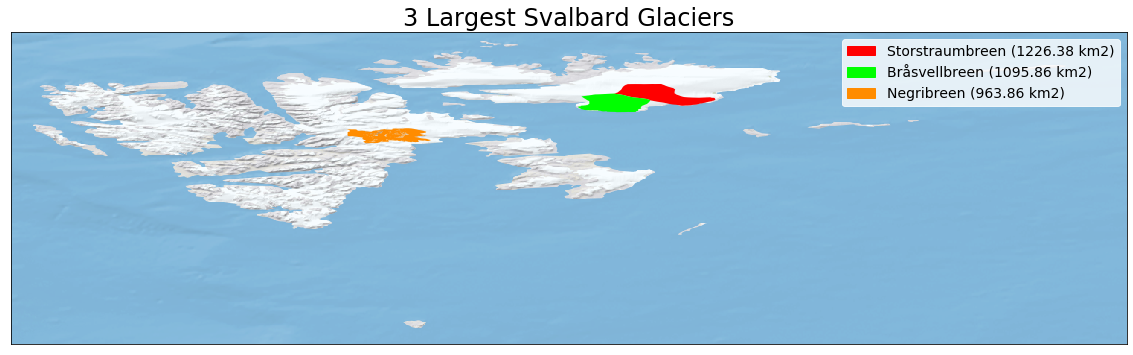

In [69]:
# Plot 3 largest Svalbard glaciers on natural earth
# Set up legend.
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_sv_glacier_df['glac_name'][0] + ' (' + str(round(final_sv_glacier_df['area_km2'][0], 2)) + ' km2)',
                 final_sv_glacier_df['glac_name'][1] + ' (' + str(round(final_sv_glacier_df['area_km2'][1], 2)) + ' km2)',
                 final_sv_glacier_df['glac_name'][2] + ' (' + str(round(final_sv_glacier_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = svalbard_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_largest_glaciers_df.iloc[0:1].plot(ax=ax, color='red')
glims_largest_glaciers_df.iloc[1:2].plot(ax=ax, color='lime')
glims_largest_glaciers_df.iloc[2:3].plot(ax=ax, color='darkorange')
ax.set_title('3 Largest Svalbard Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Save the Svalbard Final Glacier Data Frame to Shapefile

In [70]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
zipfile_sv_gl_fp = "data/final-dataset/region-" + region_number + "-largest-glaciers.zip"
if os.path.exists(zipfile_sv_gl_fp) == False:
    # Create the shapefile
    final_sv_gl_fp = "data/final-dataset/region-" + region_number + "-largest-glaciers.shp"
    final_sv_glacier_df.to_file(driver='ESRI Shapefile', filename=final_sv_gl_fp)
    print("Saving data file: " + final_sv_gl_fp)
    
    # Zip up the shapefile
    zipfile_sv_gl_fp = ws.zipshp(final_sv_gl_fp, Delete=True)
    print("Creating zipfile: " + zipfile_sv_gl_fp)
else:
    print(zipfile_sv_gl_fp + " already extists")

Saving data file: data/final-dataset/region-7-largest-glaciers.shp
Creating zipfile: data/final-dataset\region-7-largest-glaciers.zip


## Jan Mayen

In [71]:
# Open RGI Jan Mayen 3 largest (Note GLIMS doesn't have jan mayen outlines)
rgi_jan_mayen_largest_fn = "data/rgi/processed/largest/rgi_region_" + region_number + "_jan_mayen_largest.shp"
jan_mayen_largest_df = gpd.read_file(rgi_jan_mayen_largest_fn)

In [72]:
jan_mayen_largest_df

RGIId         GLIMSId    Area                         Name  \
0  RGI60-07.01569  G351730E71043N  16.876   NO4W00110002 Kpr Olavs Bre   
1  RGI60-07.01568  G351816E71042N  15.399        NO4W00110001 Sorbreen   
2  RGI60-07.01570  G351719E71067N   9.053  NO4W00110003 Kerckhoffbreen   

    BgnDate                                           geometry  
0  19759999  POLYGON ((-8.163816320999956 71.07759836600007...  
1  19759999  POLYGON ((-8.152296709999973 71.06584745900005...  
2  19759999  POLYGON ((-8.265639263999958 71.07746787900004...

### Create the Final Jan Mayen Data Frame so that it can be Saved to Shapefile

In [73]:
# Drop columns that are not needed for the final data
final_jm_glacier_df = jan_mayen_largest_df.drop(['RGIId'], axis=1)

# Add region number column
final_jm_glacier_df['region_no'] = region_number

# Add region_name column
final_jm_glacier_df['reg_name'] = region_name

# Add primary class (primeclass) column. 
final_jm_glacier_df['primeclass'] = primeclass2

# Reorder the columns of the dataframe
final_jm_glacier_df = final_jm_glacier_df[['region_no', 'reg_name', 'Name', 'GLIMSId', 
                                           'primeclass', 'Area', 'BgnDate', 'geometry']]

# Rename some columns
final_jm_glacier_df.rename(columns={'GLIMSId': 'glims_id', 'Area': 'area_km2', 
                                    'BgnDate': 'date', 'Name': 'glac_name'}, inplace=True)

# Clean and update the glacier names
final_jm_glacier_df.iloc[0, final_jm_glacier_df.columns.get_loc('glac_name')] = 'Kpr Olavsbreen'
final_jm_glacier_df.iloc[1, final_jm_glacier_df.columns.get_loc('glac_name')] = 'Sorbreen'
final_jm_glacier_df.iloc[2, final_jm_glacier_df.columns.get_loc('glac_name')] = 'Kerckhoffbreen'

# Reformat the date to YYYY-MM-DD
final_jm_glacier_df.iloc[0, final_jm_glacier_df.columns.get_loc('date')]

'19759999'

In [74]:
# Reformat the date to YYYY-MM-DD
for i, row in final_jm_glacier_df.iterrows():
    print(row['date'], row['glac_name'])
    date = row['date']
    year = date[0:4]
    month = date[4:6]
    day = date[6:8]
    # print(year + month + day)
    new_date = year + "-" + month + "-" + day
    #print(new_date)
    final_jm_glacier_df.at[i,'date'] = new_date

19759999 Kpr Olavsbreen
19759999 Sorbreen
19759999 Kerckhoffbreen


In [75]:
final_jm_glacier_df

region_no                reg_name       glac_name        glims_id  \
0         7  Svalbard and Jan Mayen  Kpr Olavsbreen  G351730E71043N   
1         7  Svalbard and Jan Mayen        Sorbreen  G351816E71042N   
2         7  Svalbard and Jan Mayen  Kerckhoffbreen  G351719E71067N   

   primeclass  area_km2        date  \
0           4    16.876  1975-99-99   
1           4    15.399  1975-99-99   
2           4     9.053  1975-99-99   

                                            geometry  
0  POLYGON ((-8.163816320999956 71.07759836600007...  
1  POLYGON ((-8.152296709999973 71.06584745900005...  
2  POLYGON ((-8.265639263999958 71.07746787900004...

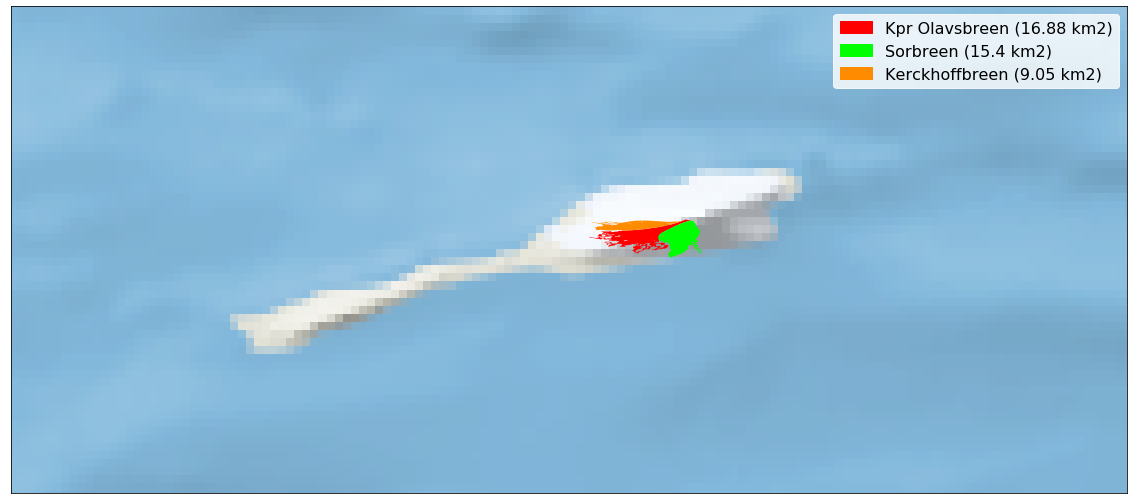

In [76]:
# Plot 3 largest Jan Mayen glaciers on natural earth
# Set up legend
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = [final_jm_glacier_df['glac_name'][0] + ' (' + str(round(final_jm_glacier_df['area_km2'][0], 2)) + ' km2)',
                 final_jm_glacier_df['glac_name'][1] + ' (' + str(round(final_jm_glacier_df['area_km2'][1], 2)) + ' km2)',
                 final_jm_glacier_df['glac_name'][2] + ' (' + str(round(final_jm_glacier_df['area_km2'][2], 2)) + ' km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = jan_mayen_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_raster,
            rgb=[0, 1, 2],
            extent=ne_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
jan_mayen_largest_df.iloc[0:1].plot(ax=ax, color='red')
jan_mayen_largest_df.iloc[1:2].plot(ax=ax, color='lime')
jan_mayen_largest_df.iloc[2:3].plot(ax=ax, color='darkorange')
#ax.set_title('3 Largest Jan Mayen Glaciers', fontsize=24)
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 16,
         bbox_to_anchor = (1.0,1.0))

plt.show()

### Save the Jan Mayen Final Glacier Data Frame to a shapefile

In [77]:
# Write dataframe to shapefile and save to zip if it doesn't already exist
# Commenting out this code since I am no longer including Jan Mayen in this analysis
#zipfile_jm_gl_fp = "data/final-dataset/region-" + region_number + "-jan-mayen-largest-glaciers.zip"
#if os.path.exists(zipfile_jm_gl_fp) == False:
#    # Create the shapefile
#    final_jm_gl_fp = "data/final-dataset/region-" + region_number + "-jan-mayen-largest-glaciers.shp"
#    final_jm_glacier_df.to_file(driver='ESRI Shapefile', filename=final_jm_gl_fp)
#    print("Saving data file: " + final_jm_gl_fp)
    
#    # Zip up the shapefile
#    zipfile_jm_gl_fp = ws.zipshp(final_jm_gl_fp, Delete=True)
#    print("Creating zipfile: " + zipfile_jm_gl_fp)
#else:
#    print(zipfile_jm_gl_fp + " already extists")

## Stop running notebook here
This next block of code will stop the notebook here. If you want to run the "Mess around with CRS" blocks, then comment out the following code block. This way, you can use "Run All" but not have to worry about running these.

In [78]:
class StopExecution(Exception):
    def _render_traceback_(self):
        pass

print("Stopping notebook")
raise StopExecution

Stopping notebook


### Mess around with CRS

In [ ]:
# Open natural earth basemap TIF file with epsg 3049 as crs
# ne_fp = 'data/natural-earth/NE1_50m_SR/NE1_50M_SR.tif' # 50 m res
ne_3049_fp = 'data/natural-earth/NE1_HR_LC_SR_W/NE1_HR_LC_SR_W_epsg3049.tif' # 10 m res
with rio.open(ne_3049_fp) as ne_3049_src:
    # Convert / read the data into a numpy array:
    ne_3049_raster = ne_3049_src.read()
    ne_3049_src_extent = plotting_extent(ne_3049_src)
    bounds_3049 = ne_3049_src.bounds
    ne_3049_raster_meta = ne_3049_src.meta

In [ ]:
ne_3049_raster_meta

In [ ]:
ten_lg_region_7_svb_ex_3049_df_2 = ten_lg_region_7_svb_ex_3049_df.to_crs({'init': 'epsg:3049'})
ten_lg_region_7_svb_ex_3049_df_2.crs

In [ ]:
ten_lg_region_7_jm_ex_3058_df_2 = ten_lg_region_7_jm_ex_3058_df.to_crs({'init': 'epsg:3049'})
ten_lg_region_7_jm_ex_3058_df_2.crs

In [ ]:
glacier_regions_3049 = glacier_regions.to_crs({'init': 'epsg:3049'})
glacier_regions_3049.crs

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

# Plot epsg 3049 natural earth basemap for Region 7
ep.plot_rgb(ne_3049_raster,
            rgb=[0, 1, 2],
            extent=ne_3049_src_extent,
            ax=ax)

# Plot region 7 outline
glacier_regions_3049[6:7].boundary.plot(ax=ax, color="black")

plt.show()

In [ ]:
# Plot all region 7 ice caps in one frame (this is from the exploded file)
# Set up plot space
fig, ax = plt.subplots(figsize=(20, 20))
minx, miny, maxx, maxy = glacier_regions_3049.loc[6:6].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap for Region 7
ep.plot_rgb(ne_3049_raster,
            rgb=[0, 1, 2],
            extent=ne_3049_src_extent,
            ax=ax)

# Plot largest (note jan mayen is very small at the bottom left corner)
ten_lg_region_7_svb_ex_3049_df_2.plot(ax=ax, color="darkorange")
ten_lg_region_7_jm_ex_3058_df_2.plot(ax=ax, color="darkorange")
ax.set_title('Region 7 Ice Caps (exploded)', fontsize=24)
# ax.set_axis_off()

In [ ]:
# Create a clipping polygon for Svalbard area with crs epsg:3049
# Create dataframe that holds the clipping box
svalbard_points = Polygon([(13949.62, 9117485.33), (430196.53, 8995611.98),
                                 (377017.41, 8216166.63), (-359770.34, 8426461.92), 
                                 (13949.62, 9117485.33)])
svalbard_gdf_3049 = gpd.GeoDataFrame([1],
                                 geometry=[svalbard_points],
                                 crs={'init': 'epsg:3049'})

In [ ]:
# Convert glims largest gdf from epsg 4326 to epsg 3049
glims_largest_glaciers_df_3049 = glims_largest_glaciers_df.to_crs({'init': 'epsg:3049'})

In [ ]:
# Plot 3 largest Svalbard glaciers on natural earth in EPSG 3049
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = ['Austfonna Basin 3 Glacier (1226.38 km2)',
                 'Bråsvellbreen Glacier (1095.86 km2)', 'Negribreen Glacier (963.86 km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = svalbard_gdf_3049.total_bounds
# minx, miny, maxx, maxy = glacier_regions_3049.loc[6:6].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_3049_raster,
            rgb=[0, 1, 2],
            extent=ne_3049_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
glims_largest_glaciers_df_3049.iloc[0:1].plot(ax=ax, color='red')
glims_largest_glaciers_df_3049.iloc[1:2].plot(ax=ax, color='lime')
glims_largest_glaciers_df_3049.iloc[2:3].plot(ax=ax, color='darkorange')
#ax.set_title('3 Largest Svalbard Glaciers', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()

In [ ]:
# Convert ice caps from 4326 to 3049
svalbard_1_ic_md_3049_df = svalbard_1_ic_md_df.to_crs({'init': 'epsg:3049'})
#olaf_clip_ex_3049_region = olaf_clip_ex_region.to_crs({'init': 'epsg:3049'})
asgard_clip_ex_3049_region = asgardfonna_ex_ic_df.to_crs({'init': 'epsg:3049'})
svalbard_3_ic_md_3049_df = svalbard_3_ic_md_df.to_crs({'init': 'epsg:3049'}) # Asgard manual dissolve
svalbard_2_ic_md_3049_df = svalbard_2_ic_md_df.to_crs({'init': 'epsg:3049'}) 

In [ ]:
# Plot 3 largest Svalbard glaciers on natural earth in EPSG 3049
# Set up legend. Note that the sizes come from an average of GLIMS and RGI. 
# See wgms-glacier-project/data/comparison/compare-glims-rgi.xlsx
legend_colors = ['red', 'lime', 'darkorange']
legend_labels = ['Austfonna Ice Cap (8082.25 km2)',
                 'Vestfonna Ice Cap (2382.83 km2)', 'Asgard Ice Cap (1546.87 km2)']
legend_patches = [Patch(color=icolor, label=label)
                  for icolor, label in zip(legend_colors, legend_labels)]

# Set up plot space
fig, ax = plt.subplots(figsize=(20,20))
minx, miny, maxx, maxy = svalbard_gdf_3049.total_bounds
# minx, miny, maxx, maxy = glacier_regions_3049.loc[6:6].total_bounds
ax.set_xlim(minx, maxx)
ax.set_ylim(miny, maxy)

# Plot natural earth basemap
ep.plot_rgb(ne_3049_raster,
            rgb=[0, 1, 2],
            extent=ne_3049_src_extent,
            ax=ax)

# Plot 3 largest glaciers from glims dataframe
svalbard_1_ic_md_3049_df.boundary.plot(ax=ax, color='red')
#olaf_clip_ex_3049_region.boundary.plot(ax=ax, color='lime')
svalbard_2_ic_md_3049_df.boundary.plot(ax=ax, color='lime')
svalbard_3_ic_md_3049_df.boundary.plot(ax=ax, color='darkorange')
ax.set_title('3 Largest Svalbard Ice Caps', fontsize=24)
# Plot legend
ax.legend(handles=legend_patches,
         facecolor ="white",
         edgecolor = "white",
         fontsize = 14,
         bbox_to_anchor = (1.0,1.0))

plt.show()